# Tweet Emotion Recognition

## **Introduction**
This project focus to detect emotion of tweets using DAIR AI Emotion Dataset and it involves building and evaluating several machine learning and deep learning models, including SVM, Bidirectional LSTM, DistilBERT, BERT, and RoBERTa to determine which model achieves the highest performance in emotion detection.





## Preparing Tools

In [1]:
!pip install scikit-learn matplotlib seaborn pandas tensorflow optuna datasets torch transformers --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 10.1 MB/s eta 0:00:00


## Import Libries

In [2]:
# General libraries
import pandas as pd
import numpy as np
import re
import sys
import os
import random
import pickle

# Add the root directory to sys.path
sys.path.append(os.path.abspath('..'))

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import make_pipeline

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

from transformers import DistilBertTokenizerFast, RobertaTokenizerFast, BertTokenizerFast,DataCollatorWithPadding
from transformers import Trainer
from transformers import DistilBertForSequenceClassification, BertForSequenceClassification, RobertaForSequenceClassification, TrainingArguments

from google.colab import files

import torch
import torch.nn as nn

import optuna

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# load Hugging Face dataset
from datasets import load_dataset, Dataset

## Load Data

In [3]:
dataset = load_dataset("emotion")
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])
val_df = pd.DataFrame(dataset['validation'])

print(train_df.head())
print(train_df['label'].unique())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3
[0 3 2 5 4 1]


In [4]:
train_df.shape, val_df.shape, test_df.shape

((16000, 2), (2000, 2), (2000, 2))

In [5]:
train_df.tail()

,text,label
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3
15999,i know a lot but i feel so stupid because i ca...,0


In [6]:
val_df.tail()

,text,label
1995,im having ssa examination tomorrow in the morn...,0
1996,i constantly worry about their fight against n...,1
1997,i feel its important to share this info for th...,1
1998,i truly feel that if you are passionate enough...,1
1999,i feel like i just wanna buy any cute make up ...,1


In [7]:
train_df["label"].value_counts()

,count
label,
1,5362
0,4666
3,2159
4,1937
2,1304
5,572


In [8]:
val_df["label"].value_counts()

,count
label,
1,704
0,550
3,275
4,212
2,178
5,81


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB


In [10]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [12]:
# Map label ID to label name
label_names = dataset["train"].features["label"].names

In [13]:
for i, label in enumerate(label_names):
    print(f"Label {i}: {label}")

Label 0: sadness
Label 1: joy
Label 2: love
Label 3: anger
Label 4: fear
Label 5: surprise


## Visualize Data

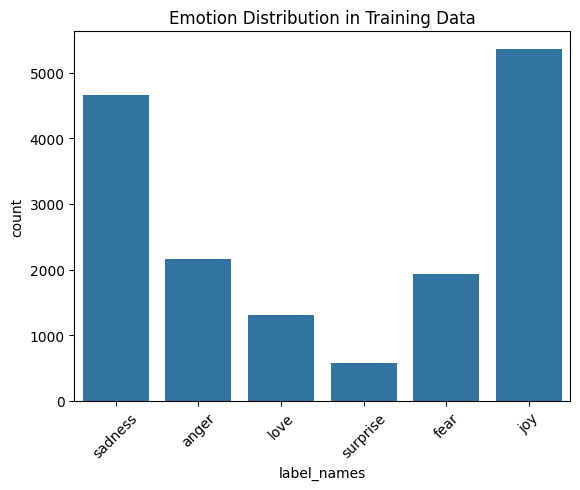

In [14]:
# Map label ID to label name in train_df
train_df['label_names'] = train_df['label'].map(lambda x: label_names[x])

sns.countplot(x='label_names', data=train_df)
plt.title('Emotion Distribution in Training Data')
plt.xticks(rotation=45) # Rotate labels for better readability
plt.show()

Here, we can clearly observe a class imbalance, particularly in the anger, love, surprise, and fear categories when compared to the sadness and joy classes. To address this imbalance, we will use a weighted training approach. The first step is to compute the class weights.

## Compute Class weights

In [15]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y= train_df['label']
)
class_weights_dict = dict(enumerate(class_weights))

for label, weight in class_weights_dict.items():
    print(f"Label {label}: {weight:.3f}")

Label 0: 0.572
Label 1: 0.497
Label 2: 2.045
Label 3: 1.235
Label 4: 1.377
Label 5: 4.662


Let's create a helper function, `compute_metrics`.

In [16]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Generate a classification report with zero_division=0 to handle classes with no predictions
    report = classification_report(labels, predictions, output_dict=True, zero_division=0)

    # Return the main averages (for model selection)
    return {
        'accuracy': report['accuracy'],
        'f1_weighted': report['weighted avg']['f1-score'],
        'precision_weighted': report['weighted avg']['precision'],
        'recall_weighted': report['weighted avg']['recall']
    }

## 1. Experiment With Suport Vector Machine

In [ ]:
train_df_svm = pd.concat([train_df, val_df], ignore_index=True)
test_df_svm = test_df.copy()

# Drop the label_names column
train_df_svm = train_df_svm.drop('label_names', axis=1)

print("Shape of train_df_svm:", train_df_svm.shape)
print("Shape of test_df_svm:", test_df_svm.shape)

Shape of train_df_svm: (18000, 2)
Shape of test_df_svm: (2000, 2)


### Preprocess text

In [ ]:
def clean_text_svm(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    return text


train_df_svm['text'] = train_df_svm['text'].apply(clean_text_svm)
test_df_svm['text'] = test_df_svm['text'].apply(clean_text_svm)

### Get train set and test set

In [ ]:
X_train_svm, y_train_svm = train_df_svm['text'], train_df_svm['label']
X_test_svm, y_test_svm = test_df_svm['text'], test_df_svm['label']

### Make pipeline with Text to Vectors (TF-IDF) and LinearSVC

In [ ]:
vectorizer = TfidfVectorizer()
svm = LinearSVC(class_weight=class_weights_dict)

pipeline = make_pipeline(
    vectorizer,
    svm
)

In [ ]:
pipeline

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('linearsvc',
                 LinearSVC(class_weight={0: np.float64(0.5715102157451064),
                                         1: np.float64(0.49732686808404825),
                                         2: np.float64(2.044989775051125),
                                         3: np.float64(1.2351397251814111),
                                         4: np.float64(1.3766993632765445),
                                         5: np.float64(4.662004662004662)}))])

In [ ]:
pipeline.fit(X_train_svm, y_train_svm)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('linearsvc',
                 LinearSVC(class_weight={0: np.float64(0.5715102157451064),
                                         1: np.float64(0.49732686808404825),
                                         2: np.float64(2.044989775051125),
                                         3: np.float64(1.2351397251814111),
                                         4: np.float64(1.3766993632765445),
                                         5: np.float64(4.662004662004662)}))])

In [ ]:
pipeline.score(X_test_svm, y_test_svm)

0.893

### Hyperparameter Tuning of SVM Using GridSearchCV

#### Define hyperparameters

In [ ]:
param_grid_svm = {
    'linearsvc__C': [0.01, 0.1, 1, 5, 10],
    'linearsvc__loss': ['hinge', 'squared_hinge'],
    'linearsvc__max_iter': [1000, 3000, 5000]
}

In [ ]:
# Use GridSearchCV
grid_search_svm = GridSearchCV(
    pipeline,
    param_grid_svm,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit on training data
grid_search_svm.fit(X_train_svm, y_train_svm)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('linearsvc',
                                        LinearSVC(class_weight={0: np.float64(0.5715102157451064),
                                                                1: np.float64(0.49732686808404825),
                                                                2: np.float64(2.044989775051125),
                                                                3: np.float64(1.2351397251814111),
                                                                4: np.float64(1.3766993632765445),
                                                                5: np.float64(4.662004662004662)}))]),
             n_jobs=-1,
             param_grid={'linearsvc__C': [0.01, 0.1, 1, 5, 10],
                         'linearsvc__loss': ['hinge', 'squared_hinge'],
                         'linearsvc__max_iter': [1000, 3000, 5000]},
             scoring='f1_weighted', verbose=2)

### Best Hyperparameters

In [ ]:
print("Best Parameters:", grid_search_svm.best_params_)
print("Best F1 Score:", grid_search_svm.best_score_)

Best Parameters: {'linearsvc__C': 1, 'linearsvc__loss': 'hinge', 'linearsvc__max_iter': 1000}
Best F1 Score: 0.8942509683354549


In [ ]:
best_model_svm = grid_search_svm.best_estimator_
best_model_svm

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('linearsvc',
                 LinearSVC(C=1,
                           class_weight={0: np.float64(0.5715102157451064),
                                         1: np.float64(0.49732686808404825),
                                         2: np.float64(2.044989775051125),
                                         3: np.float64(1.2351397251814111),
                                         4: np.float64(1.3766993632765445),
                                         5: np.float64(4.662004662004662)},
                           loss='hinge'))])

### Model evalution with testing data

In [ ]:
final_pred_svm = best_model_svm.predict(X_test_svm)

print("Tuned Model Accuracy:", accuracy_score(y_test_svm, final_pred_svm))
print(classification_report(y_test_svm, final_pred_svm, target_names=label_names))

Tuned Model Accuracy: 0.8915
              precision    recall  f1-score   support

     sadness       0.96      0.91      0.94       581
         joy       0.96      0.88      0.92       695
        love       0.70      0.96      0.81       159
       anger       0.87      0.90      0.89       275
        fear       0.86      0.84      0.85       224
    surprise       0.59      0.82      0.68        66

    accuracy                           0.89      2000
   macro avg       0.82      0.88      0.85      2000
weighted avg       0.90      0.89      0.89      2000



In [ ]:
test_results_svm = compute_metrics((best_model_svm.decision_function(X_test_svm), y_test_svm))
print("Test Results (SVM):", test_results_svm)

Test Results (SVM): {'accuracy': 0.8915, 'f1_weighted': 0.8946884112141538, 'precision_weighted': 0.9039722079843215, 'recall_weighted': 0.8915}


### Save the best model

In [ ]:
# Save the best model
with open('best_model_svm.pkl', 'wb') as f:
    pickle.dump(best_model_svm, f)

Let's look at where the model performed well and where model failed. The following code block displays random examples of correctly and incorrectly predicted tweets from the test set.

In [ ]:
# Get the true labels and predictions
y_true_svm = y_test_svm
y_pred_svm = final_pred_svm

# Get the text samples
X_samples_svm = X_test_svm

# Create lists to store correct and incorrect predictions
correct_predictions_svm = []
incorrect_predictions_svm = []

# Iterate through the test samples and compare predictions with true labels
for i in range(len(X_samples_svm)):
    text = X_samples_svm.iloc[i]
    true_label_svm = y_true_svm.iloc[i]
    predicted_label_svm = y_pred_svm[i]

    # Map label IDs to names
    true_label_name_svm = label_names[true_label_svm]
    predicted_label_name_svm = label_names[predicted_label_svm]

    if true_label_svm == predicted_label_svm:
        correct_predictions_svm.append({
            'text': text,
            'true_label': true_label_name_svm,
            'predicted_label': predicted_label_name_svm
        })
    else:
        incorrect_predictions_svm.append({
            'text': text,
            'true_label': true_label_name_svm,
            'predicted_label': predicted_label_name_svm
        })

# Display a few random correct predictions
print("--- Random Correct Predictions ---")
for _ in range(min(5, len(correct_predictions_svm))):
    prediction = random.choice(correct_predictions_svm)
    print(f"Text: {prediction['text']}")
    print(f"True Label: {prediction['true_label']}")
    print(f"Predicted Label: {prediction['predicted_label']}")
    print("-" * 20)

# Display a few random incorrect predictions
print("\n--- Random Incorrect Predictions ---")
for _ in range(min(5, len(incorrect_predictions_svm))):
    prediction = random.choice(incorrect_predictions_svm)
    print(f"Text: {prediction['text']}")
    print(f"True Label: {prediction['true_label']}")
    print(f"Predicted Label: {prediction['predicted_label']}")
    print("-" * 20)

--- Random Correct Predictions ---
Text: i no longer feel doomed to falling into the abyss with no way out
True Label: sadness
Predicted Label: sadness
--------------------
Text: i know i feel vulnerable
True Label: fear
Predicted Label: fear
--------------------
Text: i feel happy about this solution
True Label: joy
Predicted Label: joy
--------------------
Text: i feel uncomfortable telling others what is on the girls wish lists
True Label: fear
Predicted Label: fear
--------------------
Text: i feel worthless and pointless and i feel like everyones third wheel not even second
True Label: sadness
Predicted Label: sadness
--------------------

--- Random Incorrect Predictions ---
Text: i suppose if one was feeling generous one could say i was stressed by the elevator ride
True Label: joy
Predicted Label: love
--------------------
Text: i hope everyone can help with charity work without feeling stressed about such things
True Label: sadness
Predicted Label: anger
--------------------
T

Upon examining some of the incorrect predictions, it's worth noting that in certain instances, the model's predicted label appears to be a plausible interpretation of the text, suggesting potential inconsistencies or ambiguities in the original dataset's labeling.

## 2. Experiment With Bidirectional LSTM

In [ ]:
train_df_BLSTM = train_df.copy()
val_df_BLSTM = val_df.copy()
test_df_BLSTM = test_df.copy()

# Drop the label_names column
train_df_BLSTM = train_df_BLSTM.drop('label_names', axis=1)

print("Shape of train_df_BLSTM:", train_df_BLSTM.shape)
print("Shape of val_df_BLSTM:", val_df_BLSTM.shape)
print("Shape of test_df_BLSTM:", test_df_BLSTM.shape)

Shape of train_df_BLSTM: (16000, 2)
Shape of val_df_BLSTM: (2000, 2)
Shape of test_df_BLSTM: (2000, 2)


In [ ]:
train_df_BLSTM.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
def get_tweets(dataset):
    tweets = []
    labels = []
    for index, row in dataset.iterrows():
        tweets.append(row['text'])
        labels.append(label_names[row['label']])  # convert ID to label name
    return tweets, labels

In [ ]:
tweets, labels = get_tweets(train_df_BLSTM)

In [ ]:
tweets[:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

### Tokenization

In [ ]:
# fit tokenizer on train data
tokenizer_BLSTM = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer_BLSTM.fit_on_texts(tweets)

In [ ]:
tokenizer_BLSTM.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

### Padding and Truncating Sequences

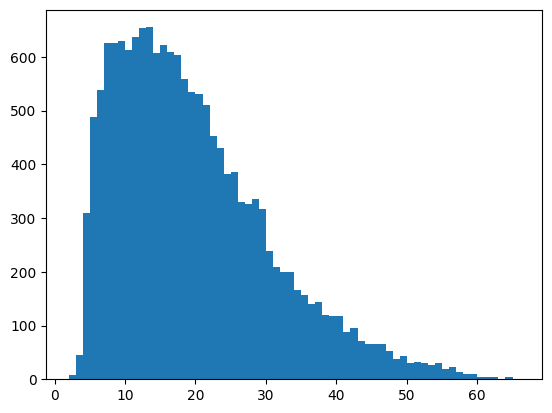

In [ ]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [ ]:
maxlen = 50

In [ ]:
def get_sequence(tokenizer,text):
    sequences = tokenizer.texts_to_sequences(text)
    padded_sequence = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
    return padded_sequence

In [ ]:
padded_train_seq = get_sequence(tokenizer_BLSTM,tweets)

In [ ]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

### Preparing Labels

In [ ]:
classes = set(labels)
print(classes)

{'surprise', 'anger', 'fear', 'love', 'sadness', 'joy'}


In [ ]:
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [ ]:
class_to_index

{'surprise': 0, 'anger': 1, 'fear': 2, 'love': 3, 'sadness': 4, 'joy': 5}

In [ ]:
index_to_class

{0: 'surprise', 1: 'anger', 2: 'fear', 3: 'love', 4: 'sadness', 5: 'joy'}

In [ ]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels = names_to_ids(labels)
print(train_labels[0])

4


### Create Model

In [ ]:
model_BLSTM = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])
model_BLSTM.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model_BLSTM.build(input_shape=(None, maxlen))

In [ ]:
model_BLSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 40)         │         5,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 40)             │         9,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,926 (687.21 KB)

 Trainable params: 175,926 (687.21 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
val_tweets, val_labels = get_tweets(val_df_BLSTM)
val_seq = get_sequence(tokenizer_BLSTM, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon',
 np.int64(4))

In [ ]:
h = model_BLSTM.fit(
      padded_train_seq, train_labels,
      validation_data=(val_seq, val_labels),
      epochs=25,
      callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)],
)

Epoch 1/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.3553 - loss: 1.5508 - val_accuracy: 0.7150 - val_loss: 0.8456
Epoch 2/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7677 - loss: 0.6678 - val_accuracy: 0.8135 - val_loss: 0.5376
Epoch 3/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8650 - loss: 0.3869 - val_accuracy: 0.8540 - val_loss: 0.4200
Epoch 4/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9199 - loss: 0.2441 - val_accuracy: 0.8555 - val_loss: 0.4114
Epoch 5/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9493 - loss: 0.1665 - val_accuracy: 0.8780 - val_loss: 0.4152
Epoch 6/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9624 - loss: 0.1218 - val_accuracy: 0.8890 - val_loss: 0.3742
Epoch 7/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.9716 - loss: 0.0994 - val_accuracy: 0.8830 - val_loss: 0.3736
Epoch 8/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.9783 - loss: 0.0805 - val_a

In [ ]:
print("Model Accuracy:", h.history['val_accuracy'][-1])

Model Accuracy: 0.9919999837875366


### Hyperparameter Tuning with Optuna

In [ ]:
def objective_BLSTM(trial):
    # Suggest hyperparameters to tune
    embedding_dim = trial.suggest_categorical("embedding_dim", [16, 32, 64, 128])
    lstm_units = trial.suggest_int("lstm_units", 16, 128, step=16)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = trial.suggest_int("epochs", 8, 25)

    # Build the BiLSTM model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, embedding_dim),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(6, activation='softmax')
    ])

    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    # Train model
    history = model.fit(
        padded_train_seq,
        train_labels,
        validation_data=(val_seq, val_labels),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights_dict,
        verbose=0,  # silent training
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)]
    )

    # Evaluate on validation set
    val_pred = np.argmax(model.predict(val_seq, verbose=0), axis=1)
    f1 = f1_score(val_labels, val_pred, average='weighted')
    return f1

# Run Optuna study
study_BLSTM = optuna.create_study(direction="maximize")
study_BLSTM.optimize(objective_BLSTM, n_trials=15, timeout=2*60*60)

[I 2025-10-19 10:31:20,779] A new study created in memory with name: no-name-65b03bf9-6e06-4922-85ab-64e4018e4ead
[I 2025-10-19 10:36:21,734] Trial 0 finished with value: 0.9204355566821324 and parameters: {'embedding_dim': 128, 'lstm_units': 96, 'dropout_rate': 0.2281536519643274, 'learning_rate': 0.008386517295470035, 'batch_size': 16, 'epochs': 18}. Best is trial 0 with value: 0.9204355566821324.
[I 2025-10-19 10:37:42,016] Trial 1 finished with value: 0.9351942483809373 and parameters: {'embedding_dim': 16, 'lstm_units': 128, 'dropout_rate': 0.4355212507938448, 'learning_rate': 0.003795190432511924, 'batch_size': 64, 'epochs': 18}. Best is trial 1 with value: 0.9351942483809373.
[I 2025-10-19 10:38:57,461] Trial 2 finished with value: 0.928371650843121 and parameters: {'embedding_dim': 16, 'lstm_units': 128, 'dropout_rate': 0.12394754333407354, 'learning_rate': 0.007800644002927178, 'batch_size': 64, 'epochs': 21}. Best is trial 1 with value: 0.9351942483809373.
[I 2025-10-19 10:40

In [ ]:
best_params_BLSTM = study_BLSTM.best_params
print("Best hyperparameters found: ", best_params_BLSTM)

Best hyperparameters found:  {'embedding_dim': 16, 'lstm_units': 128, 'dropout_rate': 0.4355212507938448, 'learning_rate': 0.003795190432511924, 'batch_size': 64, 'epochs': 18}


### Train Model with best Parameters

In [ ]:
best_model_params_BLSTM = {
    "embedding_dim": best_params_BLSTM["embedding_dim"],
    "lstm_units": best_params_BLSTM["lstm_units"],
    "dropout_rate": best_params_BLSTM["dropout_rate"]
}

best_training_params_BLSTM = {
    "learning_rate": best_params_BLSTM["learning_rate"],
    "batch_size": best_params_BLSTM["batch_size"],
    "epochs": best_params_BLSTM["epochs"]
}


In [ ]:
# Load model with best hyperparameters
model_BLSTM = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, best_model_params_BLSTM["embedding_dim"]),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(best_model_params_BLSTM["lstm_units"], return_sequences=True)
    ),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(best_model_params_BLSTM["lstm_units"])
    ),
    tf.keras.layers.Dropout(best_model_params_BLSTM["dropout_rate"]),
    tf.keras.layers.Dense(6, activation='softmax')
])

optimizer_BLSTM = tf.keras.optimizers.Adam(learning_rate=best_training_params_BLSTM["learning_rate"])
model_BLSTM.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer_BLSTM,
    metrics=['accuracy']
)

model_BLSTM.build(input_shape=(None, maxlen))

In [ ]:
history = model_BLSTM.fit(
    padded_train_seq,
    train_labels,
    validation_data=(val_seq, val_labels),
    epochs=best_training_params_BLSTM["epochs"],
    batch_size=best_training_params_BLSTM["batch_size"],
    class_weight=class_weights_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.3862 - loss: 2.4874 - val_accuracy: 0.6885 - val_loss: 1.0592
Epoch 2/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7524 - loss: 0.8244 - val_accuracy: 0.8315 - val_loss: 0.5439
Epoch 3/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8779 - loss: 0.4024 - val_accuracy: 0.8835 - val_loss: 0.3751
Epoch 4/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9122 - loss: 0.2920 - val_accuracy: 0.9080 - val_loss: 0.3345
Epoch 5/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9365 - loss: 0.2075 - val_accuracy: 0.9220 - val_loss: 0.2532
Epoch 6/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9506 - loss: 0.1516 - val_accuracy: 0.9255 - val_loss: 0.2384
Epoch 7/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9564 - loss: 0.1292 - val_accuracy: 0.9265 - val_loss: 0.2439
Epoch 8/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9633 - loss: 0.1288 - val_accu

### Model Evalution

In [ ]:
test_tweets, test_labels = get_tweets(test_df_BLSTM)
test_labels_ids = names_to_ids(test_labels)

padded_test_seq = get_sequence(tokenizer_BLSTM, test_tweets)

loss_BLSTM, accuracy_BLSTM = model_BLSTM.evaluate(padded_test_seq, test_labels_ids)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9250 - loss: 0.2600


In [ ]:
predictions_BLSTM = model_BLSTM.predict(padded_test_seq)
predicted_labels_ids_BLSTM = np.argmax(predictions_BLSTM, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [ ]:
predicted_labels_names_BLSTM = [index_to_class[i] for i in predicted_labels_ids_BLSTM]

In [ ]:
print("\nClassification Report:")
print(classification_report(test_labels, predicted_labels_names_BLSTM, target_names=label_names))


Classification Report:
              precision    recall  f1-score   support

     sadness       0.98      0.88      0.93       275
         joy       0.83      0.97      0.90       224
        love       0.91      0.98      0.94       695
       anger       0.88      0.70      0.78       159
        fear       0.97      0.97      0.97       581
    surprise       0.88      0.55      0.67        66

    accuracy                           0.92      2000
   macro avg       0.91      0.84      0.87      2000
weighted avg       0.93      0.92      0.92      2000



In [ ]:
# Use compute_metrics function to get detailed results
test_results_BLSTM = compute_metrics((predictions_BLSTM, test_labels_ids))
print("Test Results (BLSTM):", test_results_BLSTM)

Test Results (BLSTM): {'accuracy': 0.9245, 'f1_weighted': 0.9219033456570658, 'precision_weighted': 0.926013665739499, 'recall_weighted': 0.9245}


### Save the Model

In [ ]:
model_BLSTM.save("best_model_BLSTM.keras")

## 3.Experiment with DistilBERT

In [ ]:
train_df_DBERT = train_df.copy()
val_df_DBERT = val_df.copy()
test_df_DBERT = test_df.copy()

# Drop the label_names column
train_df_DBERT = train_df_DBERT.drop('label_names', axis=1)

print("Shape of train_df_DBERT:", train_df_DBERT.shape)
print("Shape of val_df_DBERT:", val_df_DBERT.shape)
print("Shape of test_df_DBERT:", test_df_DBERT.shape)

Shape of train_df_DBERT: (16000, 2)
Shape of val_df_DBERT: (2000, 2)
Shape of test_df_DBERT: (2000, 2)


In [ ]:
train_df_DBERT.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


### Tokenization

In [ ]:
# Initialize DistilBERT tokenizer
tokenizer_DBERT = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize_function_DBERT(batch):
    try:
        return tokenizer_DBERT(
            batch['text'],
            truncation=True,
            max_length=128,
            padding=False,
            return_attention_mask=True
        )
    except Exception as e:
        print(f"Tokenization error: {e}")
        raise

# Keep only required columns
train_df_DBERT = train_df_DBERT[['label', 'text']]
val_df_DBERT = val_df_DBERT[['label', 'text']]
test_df_DBERT = test_df_DBERT[['label', 'text']]

# Convert to Hugging Face Dataset objects
train_dataset_DBERT = Dataset.from_pandas(train_df_DBERT, preserve_index=False)
val_dataset_DBERT = Dataset.from_pandas(val_df_DBERT, preserve_index=False)
test_dataset_DBERT = Dataset.from_pandas(test_df_DBERT, preserve_index=False)

# Tokenize datasets
tokenized_train_DBERT = train_dataset_DBERT.map(
    tokenize_function_DBERT,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)

tokenized_val_DBERT = val_dataset_DBERT.map(
    tokenize_function_DBERT,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)

tokenized_test_DBERT = test_dataset_DBERT.map(
    tokenize_function_DBERT,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)

# sort training set by length (can improve efficiency with dynamic padding)
tokenized_train_DBERT = tokenized_train_DBERT.add_column(
    "length",
    [len(x) for x in tokenized_train_DBERT["input_ids"]]
).sort("length")


# Data collator for dynamic padding
data_collator_DBERT = DataCollatorWithPadding(
    tokenizer=tokenizer_DBERT,
    padding='longest',
    max_length=128,
    return_tensors="pt"
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_DBERT

Dataset({
    features: ['label', 'input_ids', 'attention_mask', 'length'],
    num_rows: 16000
})

### Custom Trainer to use a weighted loss

In [ ]:
class WeightedTrainer_DBERT(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        """
        Trainer that applies class weights to the loss function.

        Args:
            class_weights (dict): Dictionary of class weights computed from training set
            *args, **kwargs: Standard Trainer arguments
        """
        super().__init__(*args, **kwargs)
        # Convert class_weights dictionary to a PyTorch tensor and move to the device
        self.class_weights = torch.tensor(list(class_weights.values()), dtype=torch.float32).to(self.args.device)


    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Compute weighted loss for multi-class classification.
        """
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Weighted cross-entropy loss
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

### Optuna for Hyperparameter Tuning

In [ ]:
def objective_DBERT(trial):
    # 1. Model parameters
    model_params = {
        "dropout": trial.suggest_float("dropout_rate", 0.1, 0.5),
    }

    # 2. Training parameters
    training_params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.1),
        "per_device_train_batch_size": trial.suggest_categorical("batch_size", [8, 16, 32]),
        "num_train_epochs": trial.suggest_int("epochs", 2, 5),
        "warmup_ratio": trial.suggest_float("warmup", 0.05, 0.1),
    }

    # 3. Define the DistilBERT model
    model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=6,
        id2label={0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"},
        **model_params
    )

    # 4. Training arguments
    training_args = TrainingArguments(
        output_dir='./optuna_temp',
        eval_strategy="epoch",
        save_strategy="no",
        metric_for_best_model="eval_f1_weighted",
        greater_is_better=True,
        load_best_model_at_end=False,
        fp16=True,
        per_device_eval_batch_size=64,
        report_to="none",
        **training_params
    )

    # 5. Weighted Trainer with class weights (pass tokenized datasets and compute_metrics)
    trainer = WeightedTrainer_DBERT(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_DBERT,
        eval_dataset=tokenized_val_DBERT,
        data_collator=data_collator_DBERT,
        class_weights=class_weights_dict,
        compute_metrics=compute_metrics
    )

    # 6. Train and evaluate
    trainer.train()
    results = trainer.evaluate()

    return results['eval_f1_weighted']


# Run Optuna study
study_DBERT = optuna.create_study(direction="maximize")
study_DBERT.optimize(objective_DBERT, n_trials=10, timeout=2.5*60*60)

# Best hyperparameters
best_params_DBERT = study_DBERT.best_params
print("best_params_DBERT found: ", best_params_DBERT)

[I 2025-10-19 11:04:23,189] A new study created in memory with name: no-name-b268c686-9679-46fc-9bbe-95748f8846dd


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.347100,0.319861,0.924500,0.925307,0.927026,0.924500
2,0.248600,0.251355,0.933000,0.933695,0.936273,0.933000
3,0.171500,0.272185,0.933000,0.933234,0.933584,0.933000
4,0.138000,0.273361,0.935500,0.936153,0.937763,0.935500


[I 2025-10-19 11:09:54,597] Trial 0 finished with value: 0.9361529813381472 and parameters: {'dropout_rate': 0.1639439924799711, 'learning_rate': 1.539743881664416e-05, 'weight_decay': 0.01824961707903886, 'batch_size': 8, 'epochs': 4, 'warmup': 0.0781563265540004}. Best is trial 0 with value: 0.9361529813381472.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.320200,0.323887,0.931000,0.931316,0.932338,0.931000
2,0.178800,0.240543,0.933000,0.934002,0.938216,0.933000
3,0.122300,0.277015,0.941000,0.941268,0.942272,0.941000


[I 2025-10-19 11:13:53,132] Trial 1 finished with value: 0.9412678554009501 and parameters: {'dropout_rate': 0.1613303578509441, 'learning_rate': 4.2120243991670235e-05, 'weight_decay': 0.0259342225000654, 'batch_size': 8, 'epochs': 3, 'warmup': 0.0556044450340547}. Best is trial 1 with value: 0.9412678554009501.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.379800,0.318012,0.921000,0.921973,0.925061,0.921000
2,0.265500,0.271972,0.931500,0.932564,0.936826,0.931500


[I 2025-10-19 11:16:32,873] Trial 2 finished with value: 0.9325639565639162 and parameters: {'dropout_rate': 0.34224762754588794, 'learning_rate': 2.5620484001995392e-05, 'weight_decay': 0.09873038131605791, 'batch_size': 8, 'epochs': 2, 'warmup': 0.08099492287133704}. Best is trial 1 with value: 0.9412678554009501.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,1.052800,0.308727,0.894000,0.896116,0.905761,0.894000
2,0.312900,0.240537,0.921000,0.922356,0.930495,0.921000
3,0.213400,0.203477,0.932000,0.933141,0.938003,0.932000
4,0.180000,0.201644,0.933000,0.933876,0.937609,0.933000
5,0.154000,0.200390,0.933000,0.934045,0.938788,0.933000


[I 2025-10-19 11:18:58,869] Trial 3 finished with value: 0.9340448897438969 and parameters: {'dropout_rate': 0.43735899067425643, 'learning_rate': 4.551988454934188e-05, 'weight_decay': 0.061003366019332185, 'batch_size': 32, 'epochs': 5, 'warmup': 0.0810010985761246}. Best is trial 1 with value: 0.9412678554009501.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.422000,0.280094,0.909000,0.910469,0.915682,0.909000
2,0.221400,0.196775,0.930500,0.931426,0.936219,0.930500
3,0.173800,0.187230,0.932000,0.932993,0.935484,0.932000
4,0.136400,0.206936,0.938500,0.939152,0.941785,0.938500
5,0.109400,0.201638,0.939000,0.939628,0.941317,0.939000


[I 2025-10-19 11:22:37,580] Trial 4 finished with value: 0.9396280219038565 and parameters: {'dropout_rate': 0.1343989412292734, 'learning_rate': 1.0586678879683714e-05, 'weight_decay': 0.09485709695744501, 'batch_size': 16, 'epochs': 5, 'warmup': 0.06745201265959727}. Best is trial 1 with value: 0.9412678554009501.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.829200,0.275198,0.904500,0.906496,0.915313,0.904500
2,0.241900,0.196106,0.926500,0.927913,0.935203,0.926500
3,0.166500,0.175142,0.930000,0.931568,0.937028,0.930000
4,0.142600,0.178373,0.936000,0.937374,0.942582,0.936000


[I 2025-10-19 11:24:34,507] Trial 5 finished with value: 0.9373736755999412 and parameters: {'dropout_rate': 0.3244677776193384, 'learning_rate': 3.377309795986268e-05, 'weight_decay': 0.004600985487031151, 'batch_size': 32, 'epochs': 4, 'warmup': 0.059319108751208945}. Best is trial 1 with value: 0.9412678554009501.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,1.143300,0.407856,0.866500,0.869499,0.881600,0.866500
2,0.305300,0.226850,0.923500,0.924820,0.930712,0.923500
3,0.204600,0.202662,0.931000,0.932150,0.936077,0.931000
4,0.168900,0.197176,0.927000,0.928306,0.933439,0.927000


[I 2025-10-19 11:26:31,617] Trial 6 finished with value: 0.9283060598513839 and parameters: {'dropout_rate': 0.15270066101001833, 'learning_rate': 1.0116305958568743e-05, 'weight_decay': 0.053362275211017655, 'batch_size': 32, 'epochs': 4, 'warmup': 0.07413712346678215}. Best is trial 1 with value: 0.9412678554009501.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.883900,0.266899,0.908500,0.910430,0.918582,0.908500
2,0.218600,0.180959,0.932500,0.933802,0.939849,0.932500
3,0.153900,0.166210,0.934500,0.935488,0.938466,0.934500
4,0.123100,0.161041,0.934500,0.935659,0.940005,0.934500


[I 2025-10-19 11:28:28,638] Trial 7 finished with value: 0.9356593392324754 and parameters: {'dropout_rate': 0.16350128176485607, 'learning_rate': 1.9061866513490205e-05, 'weight_decay': 0.012805137673210055, 'batch_size': 32, 'epochs': 4, 'warmup': 0.0696284161633013}. Best is trial 1 with value: 0.9412678554009501.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.337700,0.311653,0.927000,0.927526,0.929264,0.927000
2,0.228200,0.252230,0.935000,0.935916,0.939498,0.935000
3,0.167400,0.267401,0.933500,0.933822,0.934565,0.933500
4,0.135300,0.277357,0.940000,0.940437,0.941648,0.940000


[I 2025-10-19 11:33:45,615] Trial 8 finished with value: 0.9404371907470434 and parameters: {'dropout_rate': 0.17087755807147842, 'learning_rate': 1.956284584837295e-05, 'weight_decay': 0.027631479445558816, 'batch_size': 8, 'epochs': 4, 'warmup': 0.0942429917229734}. Best is trial 1 with value: 0.9412678554009501.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.511300,0.339504,0.899000,0.900470,0.904518,0.899000
2,0.365800,0.306258,0.920500,0.921995,0.928147,0.920500
3,0.330800,0.284299,0.924500,0.925359,0.928938,0.924500
4,0.287400,0.271610,0.931500,0.932673,0.937408,0.931500
5,0.246400,0.279348,0.931000,0.931968,0.935582,0.931000


[I 2025-10-19 11:40:21,587] Trial 9 finished with value: 0.9319676211752775 and parameters: {'dropout_rate': 0.4706126298982455, 'learning_rate': 2.036027906963252e-05, 'weight_decay': 0.06503363988002635, 'batch_size': 8, 'epochs': 5, 'warmup': 0.06726738598018832}. Best is trial 1 with value: 0.9412678554009501.


best_params_DBERT found:  {'dropout_rate': 0.1613303578509441, 'learning_rate': 4.2120243991670235e-05, 'weight_decay': 0.0259342225000654, 'batch_size': 8, 'epochs': 3, 'warmup': 0.0556044450340547}


In [ ]:
best_params_DBERT

{'dropout_rate': 0.1613303578509441,
 'learning_rate': 4.2120243991670235e-05,
 'weight_decay': 0.0259342225000654,
 'batch_size': 8,
 'epochs': 3,
 'warmup': 0.0556044450340547}

### Train the model with best hyperparameters

In [ ]:
best_model_params_DBERT = {
    "dropout": best_params_DBERT["dropout_rate"]
}

best_training_params_DBERT = {
    "learning_rate": best_params_DBERT["learning_rate"],
    "weight_decay": best_params_DBERT["weight_decay"],
    "per_device_train_batch_size": best_params_DBERT["batch_size"],
    "num_train_epochs": best_params_DBERT["epochs"],
    "warmup_ratio": best_params_DBERT["warmup"]
}

In [ ]:
#Load model
model_DBERT = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=6,
    id2label={0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"},
    **best_model_params_DBERT
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training arguments
training_args_DBERT = TrainingArguments(
    output_dir="./DistilBERTTweetEmotionRecognitionModel",
    eval_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="eval_f1_weighted",
    greater_is_better=True,
    load_best_model_at_end=True,
    fp16=True,
    per_device_eval_batch_size=64,
    report_to="none",
    **best_training_params_DBERT
)

# Trainer with class weights
trainer_DBERT = WeightedTrainer_DBERT(
      model=model_DBERT,
      args=training_args_DBERT,
      train_dataset=tokenized_train_DBERT,
      eval_dataset=tokenized_val_DBERT,
      data_collator=data_collator_DBERT,
      class_weights=class_weights_dict,
      compute_metrics=compute_metrics
)

In [ ]:
trainer_DBERT.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.317800,0.299516,0.928500,0.928998,0.931649,0.928500
2,0.182900,0.208768,0.934000,0.934716,0.938792,0.934000
3,0.106800,0.270282,0.940000,0.940381,0.941428,0.940000


TrainOutput(global_step=6000, training_loss=0.30331697781880695, metrics={'train_runtime': 286.5612, 'train_samples_per_second': 167.503, 'train_steps_per_second': 20.938, 'total_flos': 511772553973728.0, 'train_loss': 0.30331697781880695, 'epoch': 3.0})

### Model Evalution

In [ ]:
# Evaluate the model on the test set
predictions_DBERT = trainer_DBERT.predict(tokenized_test_DBERT)

# Get the predicted labels
predicted_labels_DBERT = np.argmax(predictions_DBERT.predictions, axis=1)

# Print the classification report
print("\nClassification Report (DistilBERT):")
print(classification_report(tokenized_test_DBERT["label"], predicted_labels_DBERT, target_names=label_names))


Classification Report (DistilBERT):
              precision    recall  f1-score   support

     sadness       0.97      0.97      0.97       581
         joy       0.97      0.93      0.95       695
        love       0.78      0.91      0.84       159
       anger       0.93      0.94      0.94       275
        fear       0.90      0.90      0.90       224
    surprise       0.73      0.74      0.74        66

    accuracy                           0.93      2000
   macro avg       0.88      0.90      0.89      2000
weighted avg       0.93      0.93      0.93      2000



In [ ]:
test_results_DBERT = compute_metrics((predictions_DBERT.predictions, tokenized_test_DBERT["label"]))

In [ ]:
test_results_DBERT

{'accuracy': 0.93,
 'f1_weighted': 0.9308281943051404,
 'precision_weighted': 0.9328184648822553,
 'recall_weighted': 0.93}

### Save the model

In [ ]:
trainer_DBERT.save_model("best_model_DBERT")

In [ ]:
!zip -r best_model_DBERT.zip best_model_DBERT/
files.download("best_model_DBERT.zip")

  adding: best_model_DBERT/ (stored 0%)
  adding: best_model_DBERT/vocab.txt (deflated 53%)
  adding: best_model_DBERT/config.json (deflated 48%)
  adding: best_model_DBERT/training_args.bin (deflated 53%)
  adding: best_model_DBERT/tokenizer.json (deflated 71%)
  adding: best_model_DBERT/tokenizer_config.json (deflated 75%)
  adding: best_model_DBERT/special_tokens_map.json (deflated 42%)
  adding: best_model_DBERT/model.safetensors (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 4. Experiment with BERT

In [ ]:
train_df_BERT = train_df.copy()
val_df_BERT = val_df.copy()
test_df_BERT = test_df.copy()

# Drop the label_names column
train_df_BERT = train_df_BERT.drop('label_names', axis=1)

print("Shape of train_df_BERT:", train_df_BERT.shape)
print("Shape of val_df_BERT:", val_df_BERT.shape)
print("Shape of test_df_BERT:", test_df_BERT.shape)

Shape of train_df_BERT: (16000, 2)
Shape of val_df_BERT: (2000, 2)
Shape of test_df_BERT: (2000, 2)


### Tokenization

In [ ]:
# Initialize BERT tokenizer
tokenizer_BERT = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize_function_BERT(batch):
    try:
        return tokenizer_BERT(
            batch['text'],
            truncation=True,
            max_length=128,
            padding=False,
            return_attention_mask=True
        )
    except Exception as e:
        print(f"Tokenization error: {e}")
        raise

# Keep only required columns
train_df_BERT = train_df_BERT[['label', 'text']]
val_df_BERT = val_df_BERT[['label', 'text']]
test_df_BERT = test_df_BERT[['label', 'text']]

# Convert to Hugging Face Dataset objects
train_dataset_BERT = Dataset.from_pandas(train_df_BERT, preserve_index=False)
val_dataset_BERT = Dataset.from_pandas(val_df_BERT, preserve_index=False)
test_dataset_BERT = Dataset.from_pandas(test_df_BERT, preserve_index=False)

# Tokenize datasets
tokenized_train_BERT = train_dataset_BERT.map(
    tokenize_function_BERT,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)

tokenized_val_BERT = val_dataset_BERT.map(
    tokenize_function_BERT,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)

tokenized_test_BERT = test_dataset_BERT.map(
    tokenize_function_BERT,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)

# Sort training set by length (can improve efficiency with dynamic padding)
tokenized_train_BERT = tokenized_train_BERT.add_column(
    "length",
    [len(x) for x in tokenized_train_BERT["input_ids"]]
).sort("length")

# Data collator for dynamic padding
data_collator_BERT = DataCollatorWithPadding(
    tokenizer=tokenizer_BERT,
    padding='longest',
    max_length=128,
    return_tensors="pt"
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_BERT

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'length'],
    num_rows: 16000
})

### Custom Trainer to use a weighted loss

In [ ]:
class WeightedTrainer_BERT(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        """
        Trainer that applies class weights to the loss function.

        Args:
            class_weights (dict): Dictionary of class weights computed from training set
            *args, **kwargs: Standard Trainer arguments
        """
        super().__init__(*args, **kwargs)
        # Convert class_weights dictionary to a PyTorch tensor and move to the device
        self.class_weights = torch.tensor(list(class_weights.values()), dtype=torch.float32).to(self.args.device)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Compute weighted loss for multi-class classification (BERT version).
        """
        labels = inputs.pop("labels")
        outputs = model(**inputs)  # includes input_ids, attention_mask, token_type_ids
        logits = outputs.logits

        # Weighted cross-entropy loss
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


### Optuna for Hyperparameter Tuning

In [ ]:
def objective_BERT(trial):
    # 1. Model parameters
    model_params = {
        "hidden_dropout_prob": trial.suggest_float("hidden_dropout", 0.1, 0.3),
        "attention_probs_dropout_prob": trial.suggest_float("attn_dropout", 0.1, 0.3),
    }

    # 2. Training parameters
    training_params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.1),
        "per_device_train_batch_size": trial.suggest_categorical("batch_size", [8, 16, 32]),
        "num_train_epochs": trial.suggest_int("epochs", 2, 5),
        "warmup_ratio": trial.suggest_float("warmup", 0.05, 0.1),
    }

    # 3. Define the BERT model
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=6,
        id2label={0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"},
        **model_params
    )

    # 4. Training arguments
    training_args = TrainingArguments(
        output_dir='./optuna_temp_bert',
        eval_strategy="epoch",
        save_strategy="no",
        metric_for_best_model="eval_f1_weighted",
        greater_is_better=True,
        load_best_model_at_end=False,
        fp16=True,
        per_device_eval_batch_size=64,
        report_to="none",
        **training_params
    )

    # 5. Weighted Trainer for BERT
    trainer = WeightedTrainer_BERT(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_BERT,
        eval_dataset=tokenized_val_BERT,
        data_collator=data_collator_BERT,
        compute_metrics=compute_metrics,
        class_weights=class_weights_dict
    )

    # 6. Train and evaluate
    trainer.train()
    results = trainer.evaluate()

    return results['eval_f1_weighted']


# Run Optuna study for BERT
study_BERT = optuna.create_study(direction="maximize")
study_BERT.optimize(objective_BERT, n_trials=10, timeout=2.5*60*60)

# Best hyperparameters
best_params_BERT = study_BERT.best_params
print("Best hyperparameters for BERT found: ", best_params_BERT)


[I 2025-10-20 01:44:05,435] A new study created in memory with name: no-name-bb6a3d46-5c30-4b05-959b-b1a79b2f3110


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.411000,0.347217,0.905500,0.906537,0.910019,0.905500
2,0.291200,0.233557,0.929500,0.930433,0.934687,0.929500
3,0.235100,0.264808,0.931500,0.932021,0.933339,0.931500
4,0.200300,0.264785,0.930000,0.930880,0.933625,0.930000


[I 2025-10-20 01:55:07,713] Trial 0 finished with value: 0.9308800019304649 and parameters: {'hidden_dropout': 0.2243557185841491, 'attn_dropout': 0.10865451178593806, 'learning_rate': 1.0078882031275958e-05, 'weight_decay': 0.061146037064848016, 'batch_size': 8, 'epochs': 4, 'warmup': 0.06884898837239316}. Best is trial 0 with value: 0.9308800019304649.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.328100,0.240733,0.921500,0.922796,0.927978,0.921500
2,0.191800,0.193362,0.931000,0.932092,0.936093,0.931000


[I 2025-10-20 01:57:39,102] Trial 1 finished with value: 0.9320922698847767 and parameters: {'hidden_dropout': 0.11844356068535489, 'attn_dropout': 0.17814661022985473, 'learning_rate': 1.7320041930157937e-05, 'weight_decay': 0.007786145815532542, 'batch_size': 16, 'epochs': 2, 'warmup': 0.07693113923848688}. Best is trial 1 with value: 0.9320922698847767.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.370400,0.307432,0.917000,0.918199,0.922305,0.917000
2,0.271800,0.240747,0.932500,0.933646,0.937802,0.932500
3,0.216600,0.260353,0.931500,0.932535,0.935893,0.931500


[I 2025-10-20 02:06:37,124] Trial 2 finished with value: 0.9325348850720598 and parameters: {'hidden_dropout': 0.21958534013955122, 'attn_dropout': 0.18553199247194405, 'learning_rate': 1.3426456726542062e-05, 'weight_decay': 0.06611186433824397, 'batch_size': 8, 'epochs': 3, 'warmup': 0.07700386541445123}. Best is trial 2 with value: 0.9325348850720598.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.348000,0.272315,0.922000,0.923143,0.928787,0.922000
2,0.207400,0.163850,0.933500,0.934630,0.940465,0.933500
3,0.149300,0.189653,0.936500,0.937287,0.939960,0.936500


[I 2025-10-20 02:10:24,353] Trial 3 finished with value: 0.9372870774586942 and parameters: {'hidden_dropout': 0.2301238110915541, 'attn_dropout': 0.1969987354651545, 'learning_rate': 4.020262469231136e-05, 'weight_decay': 0.06160539151359445, 'batch_size': 16, 'epochs': 3, 'warmup': 0.07121109949093182}. Best is trial 3 with value: 0.9372870774586942.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,1.254200,0.436432,0.832500,0.837723,0.862330,0.832500
2,0.365800,0.265267,0.906000,0.907611,0.916558,0.906000
3,0.245800,0.232641,0.917500,0.918886,0.926112,0.917500


[I 2025-10-20 02:13:01,236] Trial 4 finished with value: 0.9188860310809324 and parameters: {'hidden_dropout': 0.27106397897075896, 'attn_dropout': 0.16750319315880427, 'learning_rate': 1.788762137441859e-05, 'weight_decay': 0.09950068594241168, 'batch_size': 32, 'epochs': 3, 'warmup': 0.08787475101718849}. Best is trial 3 with value: 0.9372870774586942.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,1.387700,0.482977,0.826000,0.831233,0.854075,0.826000
2,0.366100,0.243280,0.911500,0.912987,0.921077,0.911500
3,0.219800,0.214905,0.922500,0.923657,0.929302,0.922500
4,0.179900,0.207979,0.923000,0.924015,0.929620,0.923000
5,0.160900,0.201606,0.926500,0.927551,0.931984,0.926500


[I 2025-10-20 02:17:20,489] Trial 5 finished with value: 0.9275506877192357 and parameters: {'hidden_dropout': 0.24714303288581854, 'attn_dropout': 0.10621782784333061, 'learning_rate': 1.3944676055089276e-05, 'weight_decay': 0.06847656723705607, 'batch_size': 32, 'epochs': 5, 'warmup': 0.0920685772191331}. Best is trial 3 with value: 0.9372870774586942.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.356400,0.311819,0.927000,0.927705,0.929163,0.927000
2,0.229300,0.210512,0.935000,0.935629,0.939558,0.935000
3,0.165900,0.287462,0.932000,0.932318,0.932848,0.932000
4,0.149300,0.339204,0.937500,0.937817,0.938513,0.937500
5,0.095300,0.425309,0.935500,0.935505,0.935541,0.935500


[I 2025-10-20 02:28:31,471] Trial 6 finished with value: 0.9355050063734293 and parameters: {'hidden_dropout': 0.10474608612628925, 'attn_dropout': 0.2967303865758746, 'learning_rate': 2.0639804457173558e-05, 'weight_decay': 0.035848601843964205, 'batch_size': 8, 'epochs': 5, 'warmup': 0.08999201866751545}. Best is trial 3 with value: 0.9372870774586942.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.583300,0.328375,0.881000,0.883909,0.896021,0.881000
2,0.259300,0.217958,0.923000,0.924321,0.929982,0.923000
3,0.180300,0.216300,0.927000,0.928006,0.931074,0.927000
4,0.167700,0.217960,0.927500,0.928517,0.931765,0.927500


[I 2025-10-20 02:33:34,765] Trial 7 finished with value: 0.9285173142659631 and parameters: {'hidden_dropout': 0.18716288238076817, 'attn_dropout': 0.16780754318666327, 'learning_rate': 1.119962465317198e-05, 'weight_decay': 0.08855082954253511, 'batch_size': 16, 'epochs': 4, 'warmup': 0.07417211271911639}. Best is trial 3 with value: 0.9372870774586942.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,1.364300,0.621393,0.748500,0.758464,0.813945,0.748500
2,0.485400,0.318839,0.877000,0.879753,0.894244,0.877000
3,0.314000,0.277955,0.898000,0.900015,0.909199,0.898000


[I 2025-10-20 02:36:12,172] Trial 8 finished with value: 0.9000150466129563 and parameters: {'hidden_dropout': 0.2749373763058417, 'attn_dropout': 0.18814318611302228, 'learning_rate': 1.3943549217428062e-05, 'weight_decay': 0.029494444996945115, 'batch_size': 32, 'epochs': 3, 'warmup': 0.07173936087223359}. Best is trial 3 with value: 0.9372870774586942.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.485600,0.314594,0.894000,0.896033,0.904277,0.894000
2,0.253600,0.223176,0.918000,0.919270,0.924885,0.918000


[I 2025-10-20 02:38:45,306] Trial 9 finished with value: 0.9192699195237998 and parameters: {'hidden_dropout': 0.2138321055107779, 'attn_dropout': 0.20012978084348898, 'learning_rate': 1.5545246702897034e-05, 'weight_decay': 0.03277537457951725, 'batch_size': 16, 'epochs': 2, 'warmup': 0.06311255328020571}. Best is trial 3 with value: 0.9372870774586942.


Best hyperparameters for BERT found:  {'hidden_dropout': 0.2301238110915541, 'attn_dropout': 0.1969987354651545, 'learning_rate': 4.020262469231136e-05, 'weight_decay': 0.06160539151359445, 'batch_size': 16, 'epochs': 3, 'warmup': 0.07121109949093182}


In [ ]:
best_params_BERT

{'hidden_dropout': 0.2301238110915541,
 'attn_dropout': 0.1969987354651545,
 'learning_rate': 4.020262469231136e-05,
 'weight_decay': 0.06160539151359445,
 'batch_size': 16,
 'epochs': 3,
 'warmup': 0.07121109949093182}

### Train the model with best hyperparameters

In [ ]:
best_model_params_BERT = {
    "hidden_dropout_prob": best_params_BERT["hidden_dropout"],
    "attention_probs_dropout_prob": best_params_BERT["attn_dropout"]
}

best_training_params_BERT = {
    "learning_rate": best_params_BERT["learning_rate"],
    "weight_decay": best_params_BERT["weight_decay"],
    "per_device_train_batch_size": best_params_BERT["batch_size"],
    "num_train_epochs": best_params_BERT["epochs"],
    "warmup_ratio": best_params_BERT["warmup"]
}

In [ ]:
# Load BERT model
model_BERT = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=6,
    id2label={0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"},
    **best_model_params_BERT
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training arguments
training_args_BERT = TrainingArguments(
    output_dir="./BERTTweetEmotionRecognitionModel",
    eval_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="eval_f1_weighted",
    greater_is_better=True,
    load_best_model_at_end=True,
    fp16=True,
    per_device_eval_batch_size=64,
    report_to="none",
    **best_training_params_BERT
)

# Trainer with class weights
trainer_BERT = WeightedTrainer_BERT(
      model=model_BERT,
      args=training_args_BERT,
      train_dataset=tokenized_train_BERT,
      eval_dataset=tokenized_val_BERT,
      data_collator=data_collator_BERT,
      class_weights=class_weights_dict,
      compute_metrics=compute_metrics
)

In [ ]:
trainer_BERT.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.341500,0.258776,0.921000,0.922304,0.927430,0.921000
2,0.195500,0.162623,0.937000,0.938328,0.944253,0.937000
3,0.130600,0.186268,0.939000,0.939734,0.942778,0.939000


TrainOutput(global_step=3000, training_loss=0.3542400894165039, metrics={'train_runtime': 255.4535, 'train_samples_per_second': 187.901, 'train_steps_per_second': 11.744, 'total_flos': 1160328536246016.0, 'train_loss': 0.3542400894165039, 'epoch': 3.0})

### Model Evalution

In [ ]:
# Evaluate the model on the test set
predictions_BERT = trainer_BERT.predict(tokenized_test_BERT)

# Get the predicted labels
predicted_labels_BERT = np.argmax(predictions_BERT.predictions, axis=1)

# Print the classification report
print("\nClassification Report (BERT):")
print(classification_report(tokenized_test_BERT["label"], predicted_labels_BERT, target_names=label_names))


Classification Report (BERT):
              precision    recall  f1-score   support

     sadness       0.97      0.97      0.97       581
         joy       0.99      0.91      0.95       695
        love       0.76      0.97      0.86       159
       anger       0.93      0.93      0.93       275
        fear       0.88      0.90      0.89       224
    surprise       0.71      0.77      0.74        66

    accuracy                           0.93      2000
   macro avg       0.87      0.91      0.89      2000
weighted avg       0.94      0.93      0.93      2000



In [ ]:
test_results_BERT = compute_metrics((predictions_BERT.predictions, tokenized_test_BERT["label"]))

In [ ]:
test_results_BERT

{'accuracy': 0.9295,
 'f1_weighted': 0.9309419088303231,
 'precision_weighted': 0.9355858207262753,
 'recall_weighted': 0.9295}

### Save the model

In [ ]:
trainer_BERT.save_model("best_model_BERT")

In [ ]:
!zip -r best_model_BERT.zip best_model_BERT/
files.download("best_model_BERT.zip")

updating: best_model_BERT/ (stored 0%)
updating: best_model_BERT/vocab.txt (deflated 53%)
updating: best_model_BERT/config.json (deflated 50%)
updating: best_model_BERT/training_args.bin (deflated 53%)
updating: best_model_BERT/tokenizer.json (deflated 71%)
updating: best_model_BERT/tokenizer_config.json (deflated 75%)
updating: best_model_BERT/special_tokens_map.json (deflated 42%)
updating: best_model_BERT/model.safetensors (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 4. Experiment with RoBERTa

In [17]:
train_df_RoBERTa = train_df.copy()
val_df_RoBERTa = val_df.copy()
test_df_RoBERTa = test_df.copy()

# Drop the label_names column
train_df_RoBERTa = train_df_RoBERTa.drop('label_names', axis=1)

print("Shape of train_df_RoBERTa:", train_df_RoBERTa.shape)
print("Shape of val_df_RoBERTa:", val_df_RoBERTa.shape)
print("Shape of test_df_RoBERTa:", test_df_RoBERTa.shape)

Shape of train_df_RoBERTa: (16000, 2)
Shape of val_df_RoBERTa: (2000, 2)
Shape of test_df_RoBERTa: (2000, 2)


### Tokenization

In [18]:
# Initialize RoBERTa tokenizer
tokenizer_RoBERTa = RobertaTokenizerFast.from_pretrained('roberta-base')

def tokenize_function_RoBERTa(batch):
    try:
        return tokenizer_RoBERTa(
            batch['text'],
            truncation=True,
            max_length=128,
            padding=False,  # dynamic padding handled by DataCollator
            return_attention_mask=True
        )
    except Exception as e:
        print(f"Tokenization error: {e}")
        raise

# Keep only required columns
train_df_RoBERTa = train_df_RoBERTa[['label', 'text']]
val_df_RoBERTa = val_df_RoBERTa[['label', 'text']]
test_df_RoBERTa = test_df_RoBERTa[['label', 'text']]

# Convert to Hugging Face Dataset objects
train_dataset_RoBERTa = Dataset.from_pandas(train_df_RoBERTa, preserve_index=False)
val_dataset_RoBERTa = Dataset.from_pandas(val_df_RoBERTa, preserve_index=False)
test_dataset_RoBERTa = Dataset.from_pandas(test_df_RoBERTa, preserve_index=False)

# Tokenize datasets
tokenized_train_RoBERTa = train_dataset_RoBERTa.map(
    tokenize_function_RoBERTa,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)

tokenized_val_RoBERTa = val_dataset_RoBERTa.map(
    tokenize_function_RoBERTa,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)

tokenized_test_RoBERTa = test_dataset_RoBERTa.map(
    tokenize_function_RoBERTa,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)

# Sort training set by length (can improve efficiency with dynamic padding)
tokenized_train_RoBERTa = tokenized_train_RoBERTa.add_column(
    "length",
    [len(x) for x in tokenized_train_RoBERTa["input_ids"]]
).sort("length")

# Data collator for dynamic padding
data_collator_RoBERTa = DataCollatorWithPadding(
    tokenizer=tokenizer_RoBERTa,
    padding='longest',
    max_length=128,
    return_tensors="pt"
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [19]:
tokenized_train_RoBERTa

Dataset({
    features: ['label', 'input_ids', 'attention_mask', 'length'],
    num_rows: 16000
})

### Custom Trainer to use a weighted loss

In [20]:
class WeightedTrainer_RoBERTa(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        """
        Trainer that applies class weights to the loss function.

        Args:
            class_weights (dict): Dictionary of class weights computed from training set
            *args, **kwargs: Standard Trainer arguments
        """
        super().__init__(*args, **kwargs)
        # Convert class_weights dictionary to tensor and move to device
        self.class_weights = torch.tensor(list(class_weights.values()), dtype=torch.float32).to(self.args.device)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Compute weighted loss for multi-class classification (RoBERTa version).
        """
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Weighted CrossEntropyLoss
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

### Optuna for Hyperparameter Tuning

In [21]:
def objective_RoBERTa(trial):
    # 1. Model parameters
    model_params = {
        "hidden_dropout_prob": trial.suggest_float("hidden_dropout", 0.1, 0.3),
        "attention_probs_dropout_prob": trial.suggest_float("attn_dropout", 0.1, 0.3),
    }

    # 2. Training parameters
    training_params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.1),
        "per_device_train_batch_size": trial.suggest_categorical("batch_size", [8, 16, 32]),
        "num_train_epochs": trial.suggest_int("epochs", 2, 5),
        "warmup_ratio": trial.suggest_float("warmup", 0.05, 0.1),
    }

    # 3. Define the RoBERTa model
    model = RobertaForSequenceClassification.from_pretrained(
        'roberta-base',
        num_labels=6,
        id2label={0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"},
        **model_params
    )

    # 4. Training arguments
    training_args = TrainingArguments(
        output_dir='./optuna_temp_roberta',
        eval_strategy="epoch",
        save_strategy="no",
        metric_for_best_model="eval_f1_weighted",
        greater_is_better=True,
        load_best_model_at_end=False,
        fp16=True,
        per_device_eval_batch_size=64,
        report_to="none",
        **training_params
    )

    # 5. Weighted Trainer for RoBERTa
    trainer = WeightedTrainer_RoBERTa(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_RoBERTa,
        eval_dataset=tokenized_val_RoBERTa,
        data_collator=data_collator_RoBERTa,
        compute_metrics=compute_metrics,
        class_weights=class_weights_dict
    )

    # 6. Train and evaluate
    trainer.train()
    results = trainer.evaluate()

    return results['eval_f1_weighted']


# Run Optuna study for RoBERTa
study_RoBERTa = optuna.create_study(direction="maximize")
study_RoBERTa.optimize(objective_RoBERTa, n_trials=10, timeout=2.5*60*60)

# Best hyperparameters
best_params_RoBERTa = study_RoBERTa.best_params
print("Best hyperparameters for RoBERTa found: ", best_params_RoBERTa)

[I 2025-10-21 01:30:02,976] A new study created in memory with name: no-name-4be7e4a2-b3a1-4ec3-adc8-a133f7a96a44


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,1.193400,0.458320,0.831500,0.836860,0.861136,0.831500
2,0.387800,0.271847,0.901500,0.903257,0.910873,0.901500
3,0.271400,0.233604,0.913000,0.914774,0.922354,0.913000
4,0.217700,0.219367,0.916500,0.918212,0.924996,0.916500


[I 2025-10-21 01:34:11,442] Trial 0 finished with value: 0.918212317483867 and parameters: {'hidden_dropout': 0.19343675706673935, 'attn_dropout': 0.154936317953471, 'learning_rate': 1.2293371409016224e-05, 'weight_decay': 0.006650678943848066, 'batch_size': 32, 'epochs': 4, 'warmup': 0.06493390380167877}. Best is trial 0 with value: 0.918212317483867.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.451200,0.298578,0.900000,0.901869,0.908581,0.900000
2,0.264200,0.230987,0.919000,0.920380,0.925638,0.919000
3,0.192800,0.224359,0.925000,0.926345,0.931650,0.925000


[I 2025-10-21 01:38:17,621] Trial 1 finished with value: 0.9263454799005746 and parameters: {'hidden_dropout': 0.14272022615823515, 'attn_dropout': 0.23019351266021362, 'learning_rate': 1.2144241929164836e-05, 'weight_decay': 0.09169861334110627, 'batch_size': 16, 'epochs': 3, 'warmup': 0.06501756755066707}. Best is trial 1 with value: 0.9263454799005746.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.509600,0.363167,0.889500,0.891221,0.897882,0.889500
2,0.354000,0.317184,0.908000,0.909483,0.914847,0.908000


[I 2025-10-21 01:43:15,457] Trial 2 finished with value: 0.9094827286611323 and parameters: {'hidden_dropout': 0.20049333509162354, 'attn_dropout': 0.25325176470766375, 'learning_rate': 1.2859798048428361e-05, 'weight_decay': 0.020327514100863777, 'batch_size': 8, 'epochs': 2, 'warmup': 0.060030450249708905}. Best is trial 1 with value: 0.9263454799005746.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,1.453300,0.647185,0.744000,0.756294,0.810944,0.744000
2,0.545900,0.344716,0.874000,0.875788,0.891548,0.874000
3,0.349300,0.267783,0.904500,0.906520,0.915754,0.904500
4,0.273200,0.250721,0.905000,0.906954,0.916284,0.905000
5,0.230900,0.228132,0.913500,0.915132,0.921982,0.913500


[I 2025-10-21 01:47:50,157] Trial 3 finished with value: 0.9151320442527641 and parameters: {'hidden_dropout': 0.29764132246825237, 'attn_dropout': 0.22000469264942746, 'learning_rate': 3.101177968896422e-05, 'weight_decay': 0.008093409787213424, 'batch_size': 32, 'epochs': 5, 'warmup': 0.0831787950596172}. Best is trial 1 with value: 0.9263454799005746.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.459700,0.399214,0.913500,0.914561,0.920401,0.913500
2,0.247800,0.240115,0.939000,0.938957,0.940813,0.939000
3,0.173600,0.204228,0.935500,0.936064,0.938074,0.935500


[I 2025-10-21 01:55:15,586] Trial 4 finished with value: 0.9360643157628477 and parameters: {'hidden_dropout': 0.14988660666175768, 'attn_dropout': 0.17717610578045545, 'learning_rate': 2.2580891216667336e-05, 'weight_decay': 0.07102169322884262, 'batch_size': 8, 'epochs': 3, 'warmup': 0.08499235450368978}. Best is trial 4 with value: 0.9360643157628477.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,1.011400,0.688747,0.753000,0.761556,0.803482,0.753000
2,0.600400,0.439101,0.874500,0.877053,0.888177,0.874500


[I 2025-10-21 02:00:12,496] Trial 5 finished with value: 0.8770534895865785 and parameters: {'hidden_dropout': 0.2818068977449122, 'attn_dropout': 0.1807855650911853, 'learning_rate': 1.9061416380111077e-05, 'weight_decay': 0.09355632354083378, 'batch_size': 8, 'epochs': 2, 'warmup': 0.071077837640634}. Best is trial 4 with value: 0.9360643157628477.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,1.041700,0.381385,0.863000,0.866325,0.881703,0.863000
2,0.357800,0.256606,0.899000,0.900850,0.910493,0.899000


[I 2025-10-21 02:02:04,102] Trial 6 finished with value: 0.9008500406965977 and parameters: {'hidden_dropout': 0.21062877657598877, 'attn_dropout': 0.24317896096440744, 'learning_rate': 2.6796586668548816e-05, 'weight_decay': 0.02648252133167066, 'batch_size': 32, 'epochs': 2, 'warmup': 0.09456756059426798}. Best is trial 4 with value: 0.9360643157628477.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,1.796900,1.822230,0.352000,0.183290,0.123904,0.352000
2,1.797300,1.815095,0.275000,0.118627,0.075625,0.275000


[I 2025-10-21 02:07:01,500] Trial 7 finished with value: 0.11862745098039217 and parameters: {'hidden_dropout': 0.27604354386485785, 'attn_dropout': 0.2955366455938382, 'learning_rate': 2.0754669242529522e-05, 'weight_decay': 0.013141944897492009, 'batch_size': 8, 'epochs': 2, 'warmup': 0.06988896290989172}. Best is trial 4 with value: 0.9360643157628477.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,1.211200,0.392201,0.847000,0.852365,0.875557,0.847000
2,0.366200,0.253931,0.904500,0.906141,0.912349,0.904500
3,0.253700,0.203594,0.921000,0.922849,0.930074,0.921000
4,0.205800,0.193413,0.925000,0.926590,0.933310,0.925000


[I 2025-10-21 02:10:41,562] Trial 8 finished with value: 0.9265900930446304 and parameters: {'hidden_dropout': 0.16780949851137744, 'attn_dropout': 0.2555965688865507, 'learning_rate': 1.4518634720209304e-05, 'weight_decay': 0.013500835167999504, 'batch_size': 32, 'epochs': 4, 'warmup': 0.09224508154748778}. Best is trial 4 with value: 0.9360643157628477.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,1.374500,0.482561,0.815000,0.820444,0.842367,0.815000
2,0.504000,0.317485,0.878500,0.880530,0.893857,0.878500
3,0.351200,0.297052,0.893000,0.895542,0.907246,0.893000


[I 2025-10-21 02:13:27,205] Trial 9 finished with value: 0.8955421301762774 and parameters: {'hidden_dropout': 0.2683273524856076, 'attn_dropout': 0.27512838759669356, 'learning_rate': 2.840342744871513e-05, 'weight_decay': 0.09625308995659082, 'batch_size': 32, 'epochs': 3, 'warmup': 0.07645777929907999}. Best is trial 4 with value: 0.9360643157628477.


Best hyperparameters for RoBERTa found:  {'hidden_dropout': 0.14988660666175768, 'attn_dropout': 0.17717610578045545, 'learning_rate': 2.2580891216667336e-05, 'weight_decay': 0.07102169322884262, 'batch_size': 8, 'epochs': 3, 'warmup': 0.08499235450368978}


In [22]:
best_params_RoBERTa

{'hidden_dropout': 0.14988660666175768,
 'attn_dropout': 0.17717610578045545,
 'learning_rate': 2.2580891216667336e-05,
 'weight_decay': 0.07102169322884262,
 'batch_size': 8,
 'epochs': 3,
 'warmup': 0.08499235450368978}

### Train the model with best hyperparameters

In [23]:
best_model_params_RoBERTa = {
    "hidden_dropout_prob": best_params_RoBERTa["hidden_dropout"],
    "attention_probs_dropout_prob": best_params_RoBERTa["attn_dropout"]
}

best_training_params_RoBERTa = {
    "learning_rate": best_params_RoBERTa["learning_rate"],
    "weight_decay": best_params_RoBERTa["weight_decay"],
    "per_device_train_batch_size": best_params_RoBERTa["batch_size"],
    "num_train_epochs": best_params_RoBERTa["epochs"],
    "warmup_ratio": best_params_RoBERTa["warmup"]
}

In [24]:
# Load RoBERTa model
model_RoBERTa = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=6,
    id2label={0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"},
    **best_model_params_RoBERTa
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# Training arguments
training_args_RoBERTa = TrainingArguments(
    output_dir="./RoBERTaTweetEmotionRecognitionModel",
    eval_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="eval_f1_weighted",
    greater_is_better=True,
    load_best_model_at_end=True,
    fp16=True,
    per_device_eval_batch_size=64,
    report_to="none",
    **best_training_params_RoBERTa
)

# Trainer with class weights
trainer_RoBERTa = WeightedTrainer_RoBERTa(
      model=model_RoBERTa,
      args=training_args_RoBERTa,
      train_dataset=tokenized_train_RoBERTa,
      eval_dataset=tokenized_val_RoBERTa,
      data_collator=data_collator_RoBERTa,
      class_weights=class_weights_dict,
      compute_metrics=compute_metrics
)


In [26]:
trainer_RoBERTa.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.469200,0.374599,0.917500,0.918575,0.922400,0.917500
2,0.257500,0.268746,0.927500,0.928093,0.931035,0.927500
3,0.198300,0.214708,0.934500,0.935469,0.940380,0.934500


TrainOutput(global_step=6000, training_loss=0.4274763679504395, metrics={'train_runtime': 554.5288, 'train_samples_per_second': 86.56, 'train_steps_per_second': 10.82, 'total_flos': 1007307517654656.0, 'train_loss': 0.4274763679504395, 'epoch': 3.0})

### Model Evalution

In [27]:
# Evaluate the model on the test set
predictions_RoBERTa = trainer_RoBERTa.predict(tokenized_test_RoBERTa)

# Get the predicted labels
predicted_labels_RoBERTa = np.argmax(predictions_RoBERTa.predictions, axis=1)

# Print the classification report
print("\nClassification Report (RoBERTa):")
print(classification_report(tokenized_test_RoBERTa["label"], predicted_labels_RoBERTa, target_names=label_names))


Classification Report (RoBERTa):
              precision    recall  f1-score   support

     sadness       0.96      0.96      0.96       581
         joy       0.99      0.91      0.94       695
        love       0.75      0.97      0.85       159
       anger       0.91      0.92      0.91       275
        fear       0.93      0.84      0.88       224
    surprise       0.67      0.94      0.78        66

    accuracy                           0.92      2000
   macro avg       0.87      0.92      0.89      2000
weighted avg       0.93      0.92      0.92      2000



In [28]:
test_results_RoBERTa = compute_metrics((predictions_RoBERTa.predictions, tokenized_test_RoBERTa["label"]))

In [29]:
test_results_RoBERTa

{'accuracy': 0.922,
 'f1_weighted': 0.9239279610486627,
 'precision_weighted': 0.9312541158808474,
 'recall_weighted': 0.922}

### Save the model

In [30]:
trainer_RoBERTa.save_model("best_model_RoBERTa")

In [31]:
!zip -r best_model_RoBERTa.zip best_model_RoBERTa/
files.download("best_model_RoBERTa.zip")

  adding: best_model_RoBERTa/ (stored 0%)
  adding: best_model_RoBERTa/training_args.bin (deflated 53%)
  adding: best_model_RoBERTa/vocab.json (deflated 59%)
  adding: best_model_RoBERTa/model.safetensors (deflated 12%)
  adding: best_model_RoBERTa/tokenizer.json (deflated 82%)
  adding: best_model_RoBERTa/special_tokens_map.json (deflated 52%)
  adding: best_model_RoBERTa/tokenizer_config.json (deflated 75%)
  adding: best_model_RoBERTa/config.json (deflated 52%)
  adding: best_model_RoBERTa/merges.txt (deflated 53%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>